# Titanic: Machine Learning from Disaster

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
full_data = [train, test]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
import pandas_profiling
pandas_profiling.ProfileReport(train)

Number of variables,12
Number of observations,891
Total Missing (%),8.1%
Total size in memory,83.6 KiB
Average record size in memory,96.1 B
Numeric,6
Categorical,4
Boolean,1
Date,0
Text (Unique),1
Rejected,0


## Feature Engineering

### Features

- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain NaN)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin**: Cabin number of the passenger (Some entries contain NaN)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

### 1. Pclass

In [6]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


### 2. Sex

In [7]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


### 3. Create family size

In [8]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


### Check if people are alone

In [9]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


### 4. Embarked

Fill missing values with most occured value 'S'

In [10]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### 5. Fare

Fill missing values with median and categorize into 4 ranges

In [11]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean()

,CategoricalFare,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


### 6. Age

generate random numbers between (mean - std) and (mean + std), then we categorize age into 5 range

In [12]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean()

/Users/pawel/PycharmProjects/data-science/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,CategoricalAge,Survived
0,"(-0.08, 16.0]",0.513514
1,"(16.0, 32.0]",0.358277
2,"(32.0, 48.0]",0.370656
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


### 7. Name

Find title for people

In [13]:
import re

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


title impact on survival rate

In [14]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


## Data cleaning

In [15]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

print (train.head(10))

train = train.values
test  = test.values

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    1    1     0         0        0      1
1         1       1    0    2     3         1        0      3
2         1       3    0    1     1         0        1      2
3         1       1    0    2     3         0        0      3
4         0       3    1    2     1         0        1      1
5         0       3    1    1     1         2        1      1
6         0       1    1    3     3         0        1      1
7         0       3    1    0     2         0        0      4
8         1       3    0    1     1         0        0      3
9         1       2    0    0     2         1        0      3


## Classifier Comparison

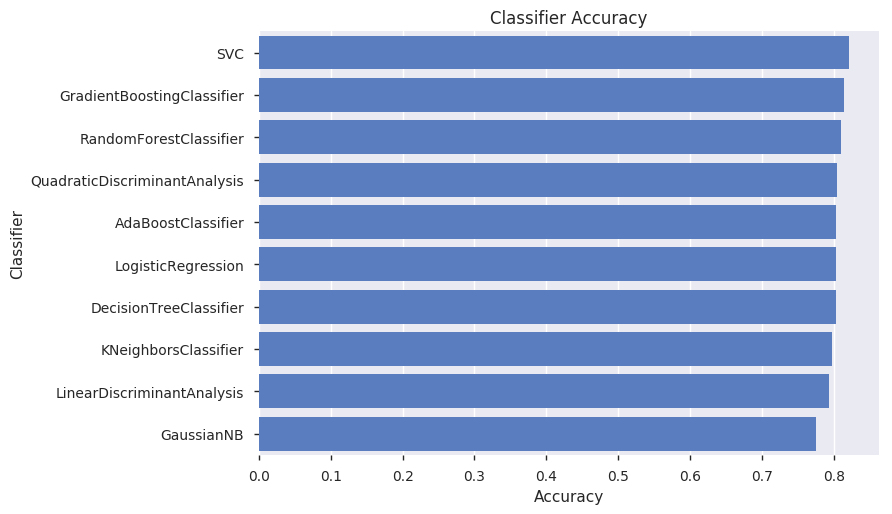

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True, gamma='auto'),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='lbfgs')]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc
            
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log.sort_values(by=['Accuracy'], ascending=False), color="b")
plt.show()